
### Load Imports ###

In [1]:
#### Load Imports ###

# Built-in
import os
import re

# Scientific and plotting
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns

# Machine Learning / Stats
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.metrics import accuracy_score
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import StratifiedKFold

# Custom / Local
from plots_with_stats import group_comparison_plot
from get_index import StimEventIndexer
from batch_process import BatchProcess
from io_secondary_properties import (
    get_basic_properties,
    get_io_properties,
    get_waveform_properties
)

# Plot parameters
mpl.rcParams.update({'font.size': 14})
sns.set(style="whitegrid", font_scale=1.5)

print('All Import Loaded')

All Import Loaded


### 1. Create index file with all cells and file properties


In [2]:
# ================= USER SETTINGS =================
main_path  = r"R:\Pantelis\for analysis\patch_data_jamie\TRAP Ephys\full_dataset"   # Root path for data
stim_types = ['io', 'rh', 'ch', 'sch']                                 # Stimulation protocols
data_ch    = 0                                                         # Voltage channel index
stim_ch    = 1                                                         # Stimulus/current channel index
sep        = '_'                                                       # Folder name delimiter
output_csv = os.path.join(main_path, 'index.csv')                      # Save location
# ================================================

indexer = StimEventIndexer(main_path, stim_types, data_ch, stim_ch, sep)
event_df = indexer.build_event_index()
event_df.to_csv(output_csv, index=False)

# Summary
total_files  = event_df['file_name'].nunique() if not event_df.empty else 0
total_events = len(event_df)
print(f"📁 Indexed {total_files} files, found {total_events} stim events.")
display(event_df)

📁 Indexed 38 files, found 139 stim events.


,file_path,file_name,stim_type,block,start_sample,stop_sample,data_ch,stim_ch,fs,condition_0
0,r:\pantelis\for analysis\patch_data_jamie\trap...,exttrap10_051925.adicht,io,0,29501,416000,0,1,10000,exttrap
1,r:\pantelis\for analysis\patch_data_jamie\trap...,exttrap10_051925.adicht,rh,1,40501,360500,0,1,10000,exttrap
2,r:\pantelis\for analysis\patch_data_jamie\trap...,exttrap10_051925.adicht,ch,2,1239501,1844500,0,1,10000,exttrap
3,r:\pantelis\for analysis\patch_data_jamie\trap...,exttrap10_051925.adicht,sch,2,640501,1235000,0,1,10000,exttrap
4,r:\pantelis\for analysis\patch_data_jamie\trap...,exttrap11_051925.adicht,io,0,46001,437500,0,1,10000,exttrap
...,...,...,...,...,...,...,...,...,...,...
134,r:\pantelis\for analysis\patch_data_jamie\trap...,fctrapf19_061725.adicht,ch,2,1221801,1825200,0,1,10000,fctrap
135,r:\pantelis\for analysis\patch_data_jamie\trap...,fctrapf20_061725.adicht,io,0,169001,558400,0,1,10000,fctrap
136,r:\pantelis\for analysis\patch_data_jamie\trap...,fctrapf20_061725.adicht,rh,1,66801,387000,0,1,10000,fctrap
137,r:\pantelis\for analysis\patch_data_jamie\trap...,fctrapf20_061725.adicht,ch,2,57201,658600,0,1,10000,fctrap


### 2. Extract properties for all four protocols: ['io', 'rh', 'ch', 'sch']

In [3]:
 # === USER SETTINGS ===
index_csv   = os.path.join(main_path, "index.csv")
analyzed_dir = os.path.join(main_path, 'analyzed')
njobs       = 1
# =====================

idx_df = pd.read_csv(index_csv)
processor = BatchProcess(
    main_path, idx_df,
    njobs=njobs,
    stim_correction=1000,
    prominence=25
)
processor.run_all(analyzed_dir, stim_types)


io:   0%|          | 0/38 [00:00<?, ?it/s]c:\Users\pante\Documents\GitHub\spike_analysis_v2\current_clamp.py:587: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax.legend(loc='upper right')
io:  24%|██▎       | 9/38 [00:04<00:18,  1.56it/s]c:\Users\pante\miniconda3\Lib\site-packages\numpy\core\fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
c:\Users\pante\miniconda3\Lib\site-packages\numpy\core\_methods.py:129: RuntimeWarning: invalid value encountered in divide
  ret = ret.dtype.type(ret / rcount)
io_wave:   0%|          | 0/38 [00:00<?, ?it/s]c:\Users\pante\Documents\GitHub\spike_analysis_v2\current_clamp.py:587: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax.legend(loc='uppe

✅ All protocols processed.


### 3. Extract IO secondary properties (ie, waveform metrics and i-o slope, percent firing rate etc)

In [4]:
# ================= USER CONFIGURATION =================
analyzed_path    = r'R:\Pantelis\for analysis\patch_data_jamie\TRAP Ephys\full_dataset\analyzed'
stim_type    = 'io'
group_cols   = ['treatment', 'cell_id']
# =====================================================

# ===== Load extracted features =====
basic_path = os.path.join(analyzed_path, f"{stim_type}_basic/features.csv")
wave_path  = os.path.join(analyzed_path, f"{stim_type}_wave/features.csv")
df_basic   = pd.read_csv(basic_path)
df_wave    = pd.read_csv(wave_path)

# ===== Standardize column names =====
df_basic = df_basic.rename(columns={'file_name': 'cell_id', 'condition_0': 'treatment'})
df_wave  = df_wave.rename(columns={'file_name': 'cell_id', 'condition_0': 'treatment'})

# ===== Filter out non-spiking cells =====
spike_summary = df_basic.groupby('cell_id')['spike_frequency'].max().reset_index()
non_spiking = spike_summary[spike_summary['spike_frequency'] <= 0]['cell_id']
df_basic = df_basic[~df_basic['cell_id'].isin(non_spiking)].reset_index(drop=True)
df_wave  = df_wave[~df_wave['cell_id'].isin(non_spiking)].reset_index(drop=True)

# ===== Basic properties (RMP, Rin) =====
plot_basic = (
    df_basic.groupby(group_cols)[['input_resistance', 'rmp']]
    .mean()
    .reset_index()
)
plot_basic.loc[plot_basic['input_resistance'] < 0, 'input_resistance'] = np.NaN
basic_properties = get_basic_properties(plot_basic, group_cols)

# ===== IO curve properties (freq, slope, rheobase) =====
plot_io = (
    df_basic.groupby(group_cols + ['amp'])[['spike_frequency']]
    .mean()
    .reset_index()
)
plot_io = plot_io[plot_io['amp'] > 0]
io_properties = get_io_properties(plot_io, group_cols, show_plot=False)

# ===== Waveform properties (AP shape) =====
df_wave = df_wave.dropna(subset=['mV', 'time'])
waveform_properties = get_waveform_properties(df_wave, group_cols, show_plot=False)

# ===== Save outputs separately ====
summary_basic_io = io_properties.merge(basic_properties, on=group_cols, how='left')
summary_basic_io.to_csv(os.path.join(analyzed_path, f'{stim_type}_basic', 'summary_io.csv'), index=False)
waveform_properties.to_csv(os.path.join(analyzed_path, f'{stim_type}_wave', 'summary_waveform.csv'), index=False)

# ===== Save filtered feature tables without overwriting original =====
df_basic.to_csv(os.path.join(analyzed_path, f'{stim_type}_basic', 'features_filtered.csv'), index=False)
df_wave.to_csv(os.path.join(analyzed_path, f'{stim_type}_wave', 'features_filtered.csv'), index=False)

print("✅ Property extraction complete.")


✅ Property extraction complete.


### 4. Find cells with bad responses and high firing rate to exclude

In [5]:
# USER CONFIGURATION
analysis_path = r'R:\Pantelis\for analysis\patch_data_jamie\TRAP Ephys\full_dataset\analyzed'
group_col = 'treatment'
palette = ['#1f77b4', '#ff7f0e']

# Load cell metadata
path_basic_io = os.path.join(analysis_path, 'io_basic', 'summary_io.csv')
df_basic_io = pd.read_csv(path_basic_io)

# Identify cells with bad responses
bad_responses = ('fctrap5_', 'fctrap7_', 'fctrap8_', 'fctrap13_',
                 'exttrap1_', 'exttrap10_', 'exttrap12_', 'exttrap13_', 'exttrap15_')
pattern = '|'.join(map(re.escape, bad_responses))
cells_with_bad_responses = set(df_basic_io[df_basic_io['cell_id'].str.contains(pattern, case=False, na=False)]['cell_id'])

# Identify fast spiking cells ( bigger than 60 Hz)
fast_spiking = set(df_basic_io[df_basic_io['max_firing_rate'] > 60]['cell_id'])

# Combine
to_exclude = cells_with_bad_responses.union(fast_spiking)

# Summary per treatment
print(f"🔍 Found {len(cells_with_bad_responses)} cells with bad responses.")
print(f"⚡ Found {len(fast_spiking)} fast spiking cells.")
print(f"❌ Total cells to exclude: {len(to_exclude)}")

print("\n📊 Cell counts by treatment BEFORE exclusion:")
print(df_basic_io.groupby('treatment')['cell_id'].nunique())

remaining = df_basic_io[~df_basic_io['cell_id'].isin(to_exclude)]
print("\n✅ Remaining cells per treatment AFTER exclusion:")
print(remaining.groupby('treatment')['cell_id'].nunique())


🔍 Found 7 cells with bad responses.
⚡ Found 5 fast spiking cells.
❌ Total cells to exclude: 12

📊 Cell counts by treatment BEFORE exclusion:
treatment
exttrap    18
fctrap     19
Name: cell_id, dtype: int64

✅ Remaining cells per treatment AFTER exclusion:
treatment
exttrap    12
fctrap     13
Name: cell_id, dtype: int64


### 5. I-O Plot

C:\Users\pante\AppData\Local\Temp\ipykernel_17752\2031812747.py:21: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=df_rh, x='treatment', y='rheobase', palette='pastel', errorbar='se')


Text(0.5, 1.0, 'Rheobase by Treatment (RH)')

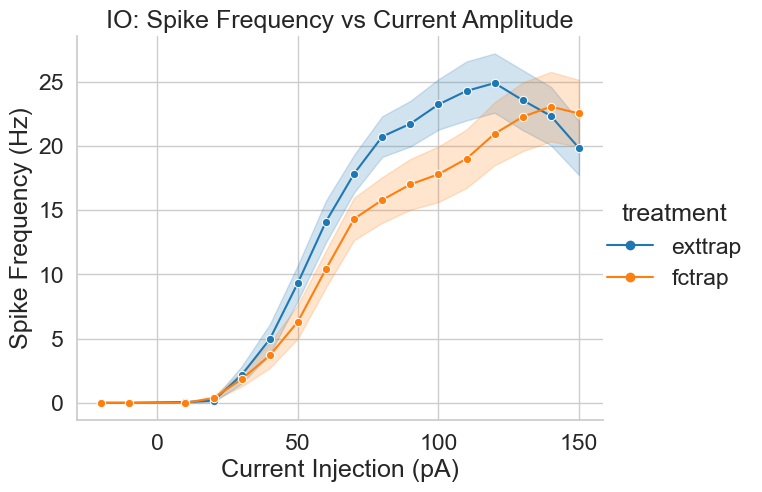

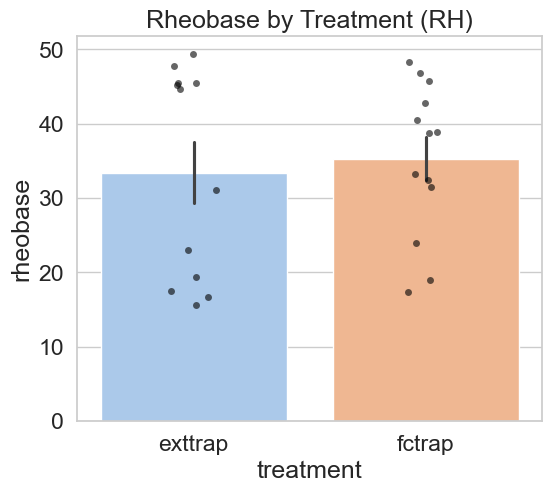

In [6]:
# ==== PLOT: IO Spike Frequency vs Amp ====
df_basic = pd.read_csv(os.path.join(analysis_path, 'io_basic', 'features_filtered.csv'))
df_basic = df_basic[~df_basic['cell_id'].isin(to_exclude)]
sns.relplot(
    data=df_basic,
    x='amp', y='spike_frequency',
    marker='o', hue='treatment',
    kind='line', errorbar='se',
    palette='tab10',
    height=5, aspect=1.3
)
plt.title('IO: Spike Frequency vs Current Amplitude')
plt.xlabel('Current Injection (pA)')
plt.ylabel('Spike Frequency (Hz)')

# ==== PLOT: Rheobase (RH) ====
df_rh = pd.read_csv(os.path.join(analysis_path, 'rh', 'features.csv'))
df_rh = df_rh.rename(columns={'file_name': 'cell_id', 'condition_0': 'treatment'})
df_rh = df_rh[~df_rh['cell_id'].isin(to_exclude)]
plt.figure(figsize=(6, 5))
sns.barplot(data=df_rh, x='treatment', y='rheobase', palette='pastel', errorbar='se')
sns.stripplot(data=df_rh, x='treatment', y='rheobase', color='black', jitter=True, alpha=0.6)
plt.title('Rheobase by Treatment (RH)')



### 6. AP Waveform (Standard Deviation)

Text(75.291875, 0.5, 'Membrane Potential (mV)')

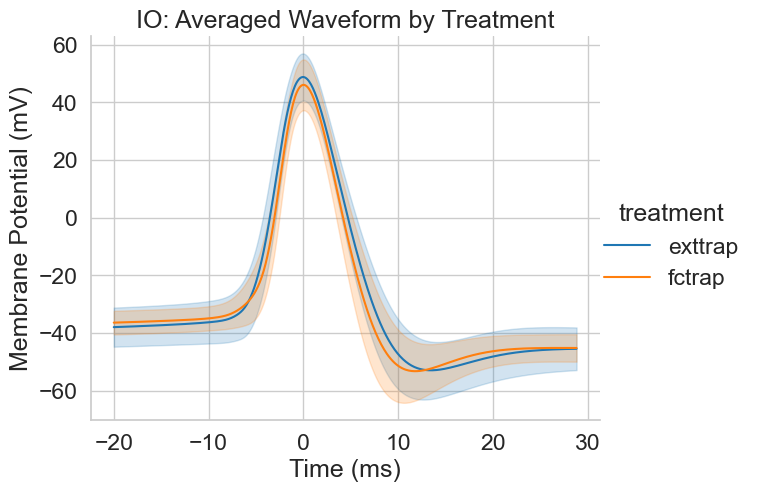

In [7]:
df_wave  = pd.read_csv(os.path.join(analysis_path, 'io_wave', 'features_filtered.csv'))
df_wave = df_wave[~df_wave['cell_id'].isin(to_exclude)]
# ==== PLOT: IO Waveform Trace ====
sns.relplot(
    data=df_wave,
    x='time', y='mV',
    hue='treatment', kind='line',
    estimator=np.mean, errorbar='sd',
    palette='tab10',
    height=5, aspect=1.3
)
plt.title('IO: Averaged Waveform by Treatment')
plt.xlabel('Time (ms)')
plt.ylabel('Membrane Potential (mV)')

### 7. IO and Waveform Properties - Summary Plots

📊 Analyzing IO features...
📊 Analyzing waveform features...


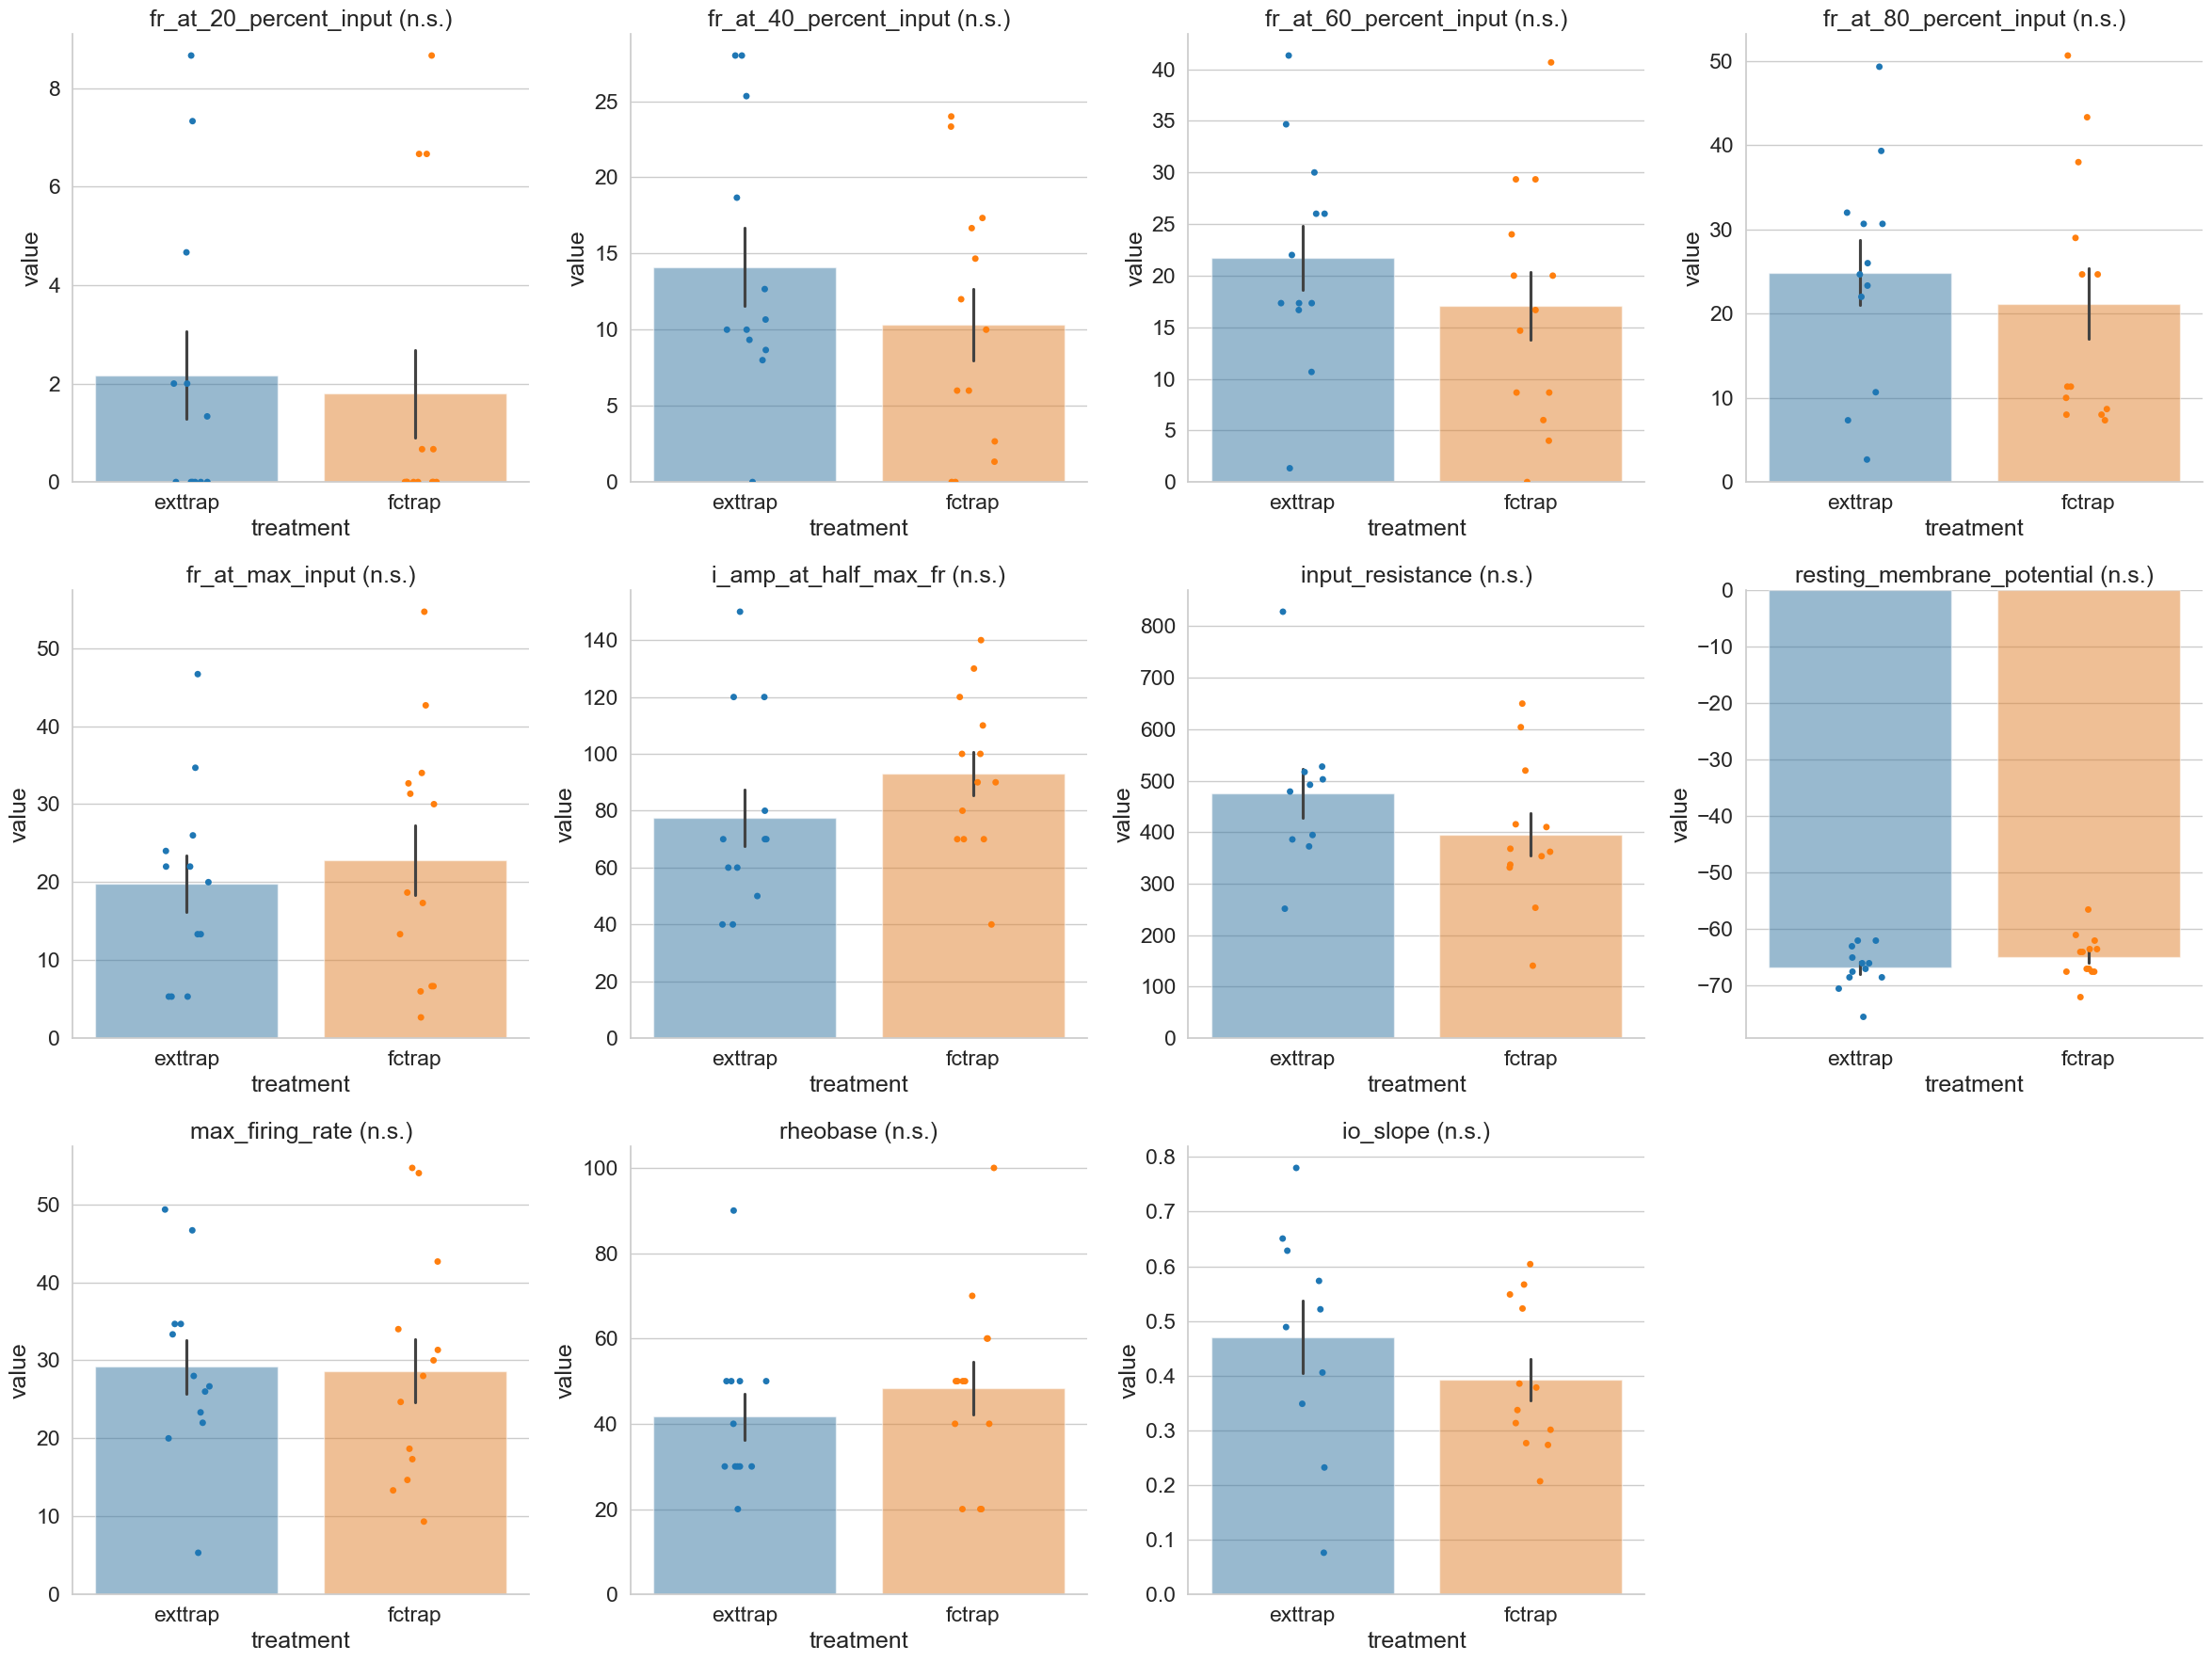

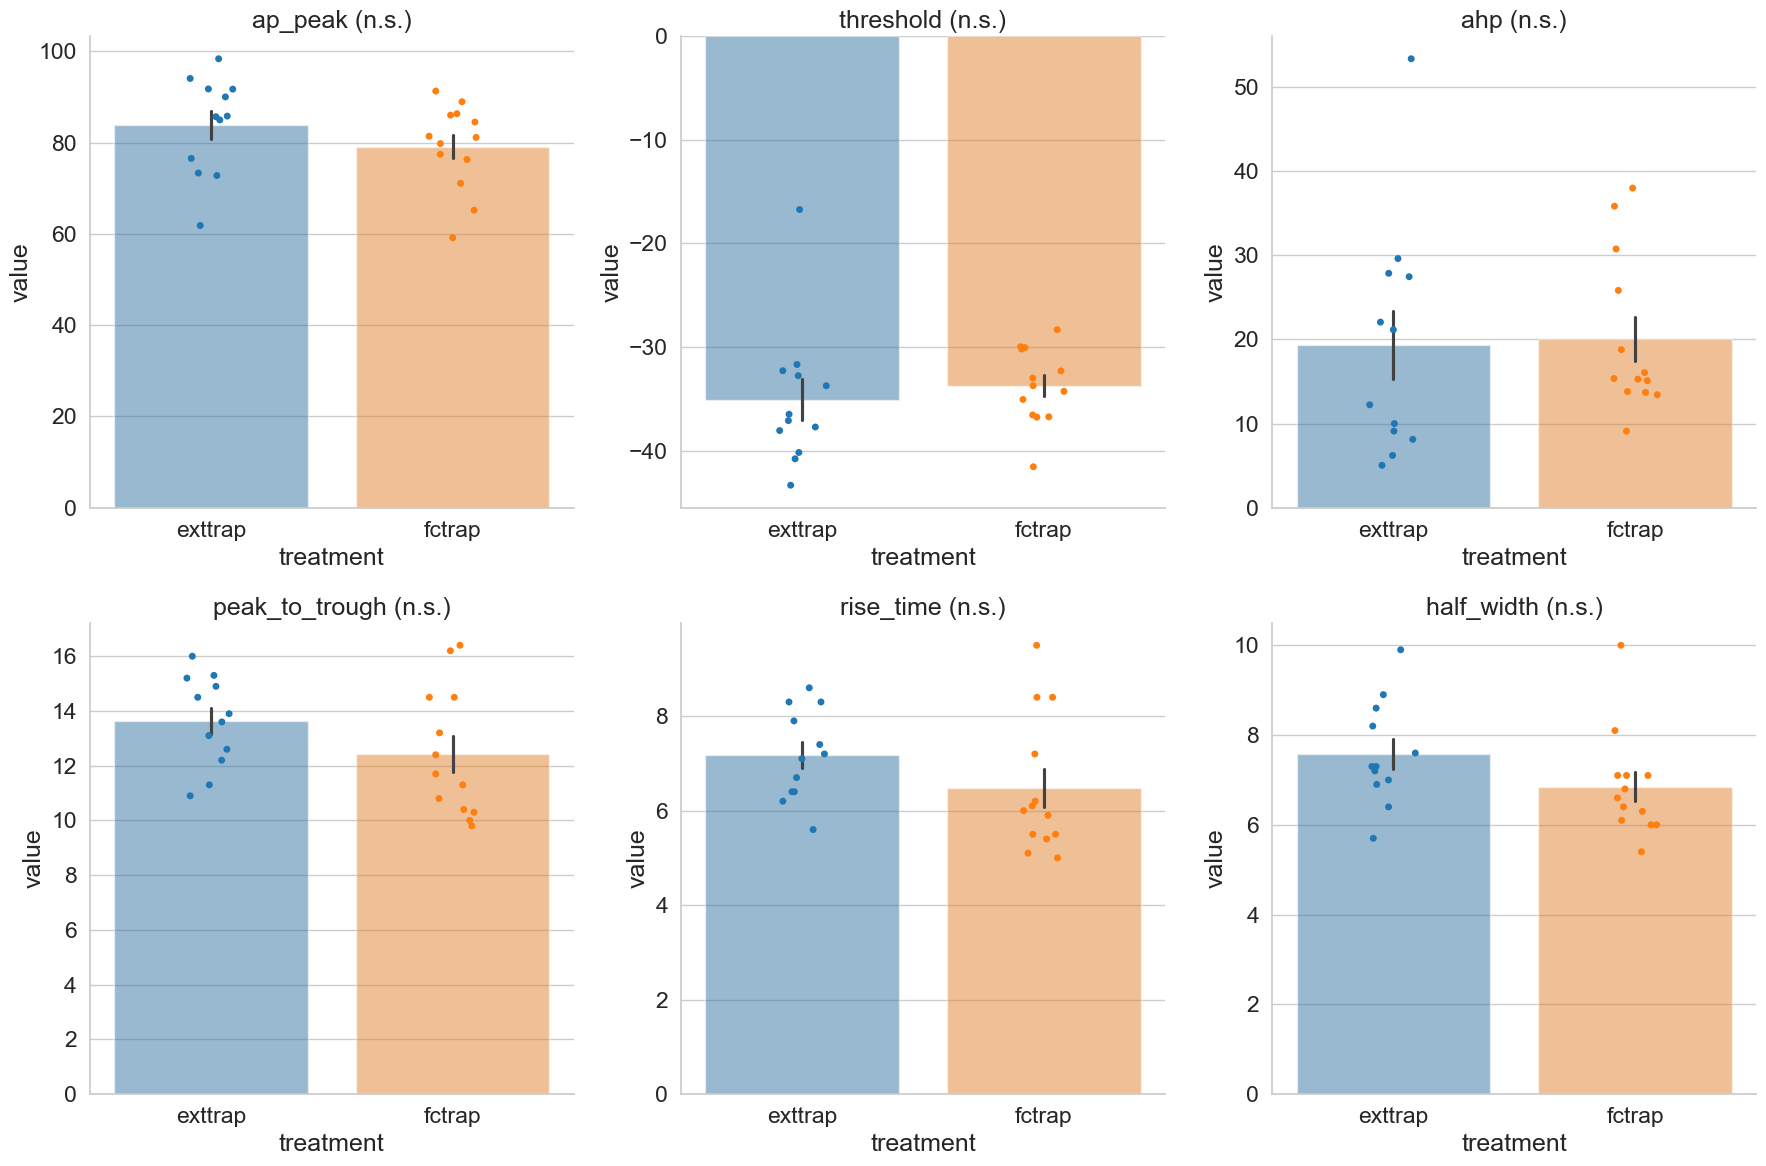

In [9]:
# Re-load to ensure no prior modification affects the input
import warnings
warnings.filterwarnings('ignore')
df_basic_io = pd.read_csv(os.path.join(analysis_path, 'io_basic', 'summary_io.csv'))
df_waveform = pd.read_csv(os.path.join(analysis_path, 'io_wave', 'summary_waveform.csv'))

# Apply exclusions
df_basic_io = df_basic_io[~df_basic_io['cell_id'].isin(to_exclude)]
df_waveform = df_waveform[~df_waveform['cell_id'].isin(to_exclude)]

# Define column sets
basic_io_cols = [
    'fr_at_20_percent_input', 'fr_at_40_percent_input', 'fr_at_60_percent_input',
    'fr_at_80_percent_input', 'fr_at_max_input', 'i_amp_at_half_max_fr',
    'input_resistance', 'resting_membrane_potential', 'max_firing_rate',
    'rheobase', 'io_slope'
]

waveform_cols = [
    'ap_peak', 'threshold', 'ahp', 'peak_to_trough', 'rise_time', 'half_width'
]

# Run and plot
print("📊 Analyzing IO features...")
res_basic_io = group_comparison_plot(
    df_basic_io,
    group_column='treatment',
    dependent_variables=basic_io_cols,
    palette=palette,
    n_cols=4
)

print("📊 Analyzing waveform features...")
res_waveform = group_comparison_plot(
    df_waveform,
    group_column='treatment',
    dependent_variables=waveform_cols,
    palette=palette,
    n_cols=3
)

### 8. PCA - Logistic regression

✅ Mean CV Accuracy: 0.480
📄 Fold Accuracies:  [0.4 0.6 0.4 0.8 0.2]


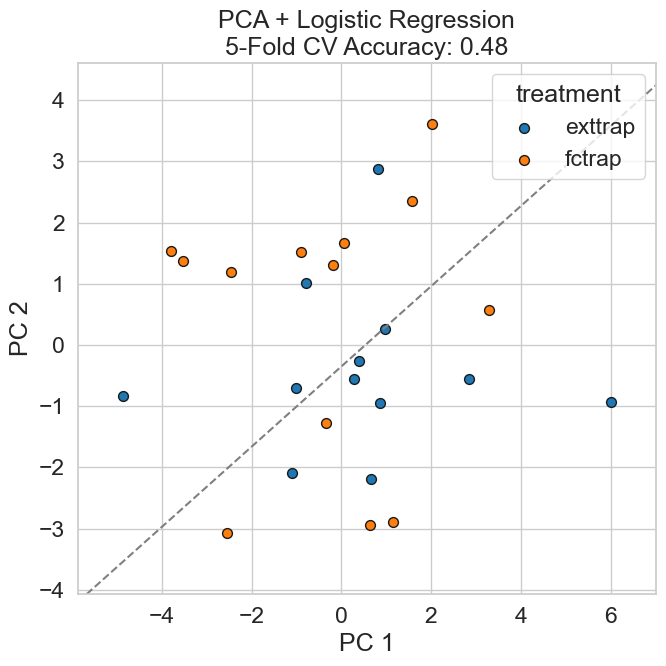

In [10]:
# ==== COMBINE, PCA + GMM CLUSTERING & PLOT ====
# 1) merge on cell_id & treatment
df_merged = pd.merge(
    df_basic_io, df_waveform,
    on=['cell_id','treatment'], how='inner'
)
df_merged = df_merged.fillna(df_merged.median(numeric_only=True))

# 2) pick features and standardize
features = basic_io_cols + waveform_cols
X = df_merged[features].values
scaler = StandardScaler()
X_scaled = scaler.fit_transform(df_merged[features].values)
y = df_merged[group_col].values

# 2. PCA to 2D for visualization & classification
pca = PCA(n_components=2, random_state=0)
X_pca = pca.fit_transform(X_scaled)

# 3. Stratified K-Fold Logistic Regression
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=0)
log_reg = LogisticRegression(solver='lbfgs', max_iter=1000)
scores = []

for train_idx, test_idx in skf.split(X_pca, y):
    X_train, X_test = X_pca[train_idx], X_pca[test_idx]
    y_train, y_test = y[train_idx], y[test_idx]
    
    log_reg.fit(X_train, y_train)
    y_pred = log_reg.predict(X_test)
    acc = accuracy_score(y_test, y_pred)
    scores.append(acc)

print(f"✅ Mean CV Accuracy: {np.mean(scores):.3f}")
print(f"📄 Fold Accuracies:  {np.round(scores, 3)}")

# 4. Final model on full PCA data
log_reg.fit(X_pca, y)

# 5. Decision boundary plot
x_min, x_max = X_pca[:, 0].min() - 1, X_pca[:, 0].max() + 1
y_min, y_max = X_pca[:, 1].min() - 1, X_pca[:, 1].max() + 1
xx, yy = np.meshgrid(
    np.linspace(x_min, x_max, 500),
    np.linspace(y_min, y_max, 500)
)
grid = np.c_[xx.ravel(), yy.ravel()]
Z = log_reg.predict_proba(grid)[:, 1].reshape(xx.shape)

# 6. Scatter + decision boundary
fig, ax = plt.subplots(figsize=(7, 7))
for tr, col in zip(np.unique(y), palette):
    mask = y == tr
    ax.scatter(X_pca[mask, 0], X_pca[mask, 1], label=tr, c=col, edgecolor='k', s=50)

ax.contour(xx, yy, Z, levels=[0.5], linestyles='--', colors='gray')
ax.set_xlabel('PC 1')
ax.set_ylabel('PC 2')
ax.set_title(f'PCA + Logistic Regression\n5-Fold CV Accuracy: {np.mean(scores):.2f}')
ax.legend(title=group_col)
plt.tight_layout()
plt.show()

### 9. Chrip (subthreshold resonance) and Short Chirp (suprathreshold spike transfer) normalize and break into bands

In [12]:
# === Setup ===
stim_types = ['ch', 'sch']
metrics = {'ch': 'impedance', 'sch': 'spike_count'}
file_paths = {s: os.path.join(analysis_path, s, 'features.csv') for s in stim_types}
freq_bins = (3, 6, 12, 15, 30, 60)

# === Requires `to_exclude` to be defined already in the notebook ===

# === Delta function ===
def compute_deltas(group, y):
    bp = group.set_index('freq_bins')[y]
    return pd.Series({
        'delta_3-6__6-12':   bp.get(pd.Interval(3, 6),  np.nan) - bp.get(pd.Interval(6, 12), np.nan),
        'delta_15-30__3-6':  bp.get(pd.Interval(15, 30), np.nan) - bp.get(pd.Interval(3, 6), np.nan),
        'delta_15-30__6-12': bp.get(pd.Interval(15, 30), np.nan) - bp.get(pd.Interval(6, 12), np.nan),
    })

# === Storage containers ===
dfs = {}                 # full df with raw and norm columns
dfs_binned_raw = {}      # grouped raw
dfs_binned_norm = {}     # grouped norm
deltas_raw = {}
deltas_norm = {}

# === Process CH and SCH ===
for stim in stim_types:
    metric = metrics[stim]
    
    # Load and clean
    df = pd.read_csv(file_paths[stim])
    df = df.rename(columns={'file_name': 'cell_id', 'condition_0': 'treatment'})
    df = df[~df['cell_id'].isin(to_exclude)].copy()

    # Remove zero-spike cells if needed
    if metric == 'spike_count':
        total = df.groupby(['cell_id', 'treatment'])[metric].transform('sum')
        df = df[total > 0]

    # Normalize
    total = df.groupby(['cell_id', 'treatment'])[metric].transform('sum')
    norm_col = f'norm_{metric}'
    df[norm_col] = df[metric] / total

    # 1) Check sums of norm values per cell×treatment
    check = (
        df
        .groupby(['cell_id', 'treatment'])[norm_col]
        .sum()
        .reset_index(name='sum_norm')
    )

    # 2) Print summaries: should all be (approximately) 1
    print(f"--- {stim.upper()} normalization check ---")
    print(f"Min sum: {check['sum_norm'].min():.4f}, Max sum: {check['sum_norm'].max():.4f}")
    print(f"Any deviating from 1? {((check['sum_norm'] < 0.999) | (check['sum_norm'] > 1.001)).any()}")
    print(check.head(), "\n")

    # Bin frequencies
    df['freq_bins'] = pd.cut(df['freq'], freq_bins)

    # Save full df
    dfs[stim] = df

    # === Binned RAW ===
    df_binned_raw = (
        df.groupby(['freq_bins', 'cell_id', 'treatment'], observed=True)[metric]
        .mean().reset_index()
    )
    dfs_binned_raw[stim] = df_binned_raw

    deltas_raw[stim] = (
        df_binned_raw.groupby(['cell_id', 'treatment'])
        .apply(compute_deltas, y=metric)
        .reset_index()
        .melt(id_vars=['cell_id', 'treatment'], var_name='delta_type', value_name=metric)
    )

    # === Binned NORM ===
    df_binned_norm = (
        df.groupby(['freq_bins', 'cell_id', 'treatment'], observed=True)[norm_col]
        .mean().reset_index()
    )
    dfs_binned_norm[stim] = df_binned_norm

    deltas_norm[stim] = (
        df_binned_norm.groupby(['cell_id', 'treatment'])
        .apply(compute_deltas, y=norm_col)
        .reset_index()
        .melt(id_vars=['cell_id', 'treatment'], var_name='delta_type', value_name=metric)
    )

--- CH normalization check ---
Min sum: 1.0000, Max sum: 1.0000
Any deviating from 1? False
                   cell_id treatment  sum_norm
0  exttrap11_051925.adicht   exttrap       1.0
1  exttrap14_060225.adicht   exttrap       1.0
2  exttrap16_060225.adicht   exttrap       1.0
3  exttrap18_061625.adicht   exttrap       1.0
4  exttrap19_061625.adicht   exttrap       1.0 

--- SCH normalization check ---
Min sum: 1.0000, Max sum: 1.0000
Any deviating from 1? False
                   cell_id treatment  sum_norm
0  exttrap11_051925.adicht   exttrap       1.0
1  exttrap14_060225.adicht   exttrap       1.0
2  exttrap16_060225.adicht   exttrap       1.0
3  exttrap18_061625.adicht   exttrap       1.0
4  exttrap19_061625.adicht   exttrap       1.0 



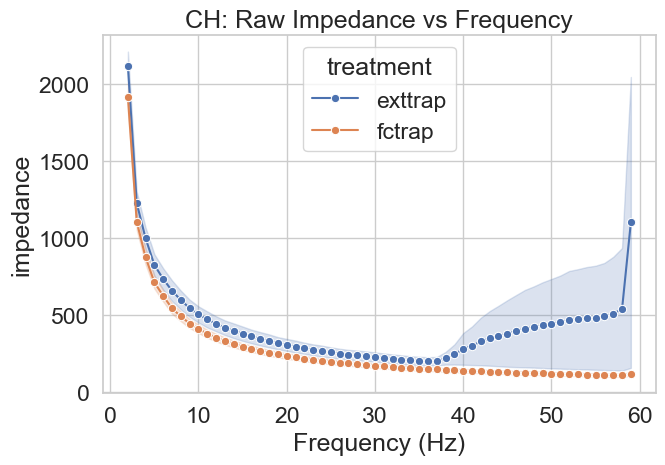

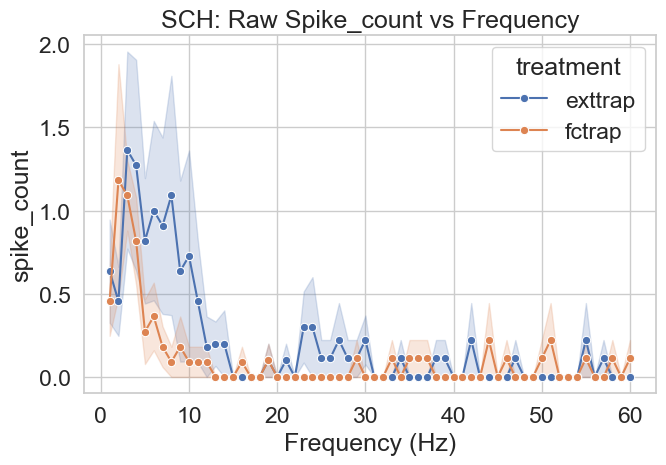

In [13]:
for stim in stim_types:
    metric = metrics[stim]
    plt.figure(figsize=(7, 5))
    sns.lineplot(data=dfs[stim], x='freq', y=metric, hue='treatment', errorbar='se', marker='o')
    plt.title(f'{stim.upper()}: Raw {metric.capitalize()} vs Frequency')
    plt.xlabel('Frequency (Hz)')
    plt.ylabel(metric)
    plt.tight_layout()
    plt.show()


### 10. Plot Normalized (normalized to sum impedance or spike counts per cell)

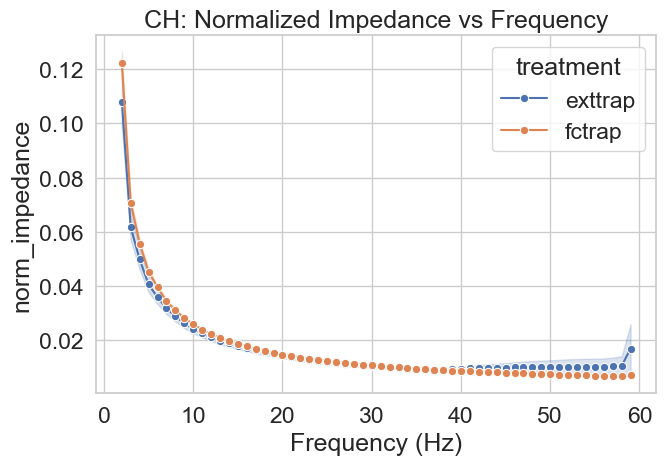

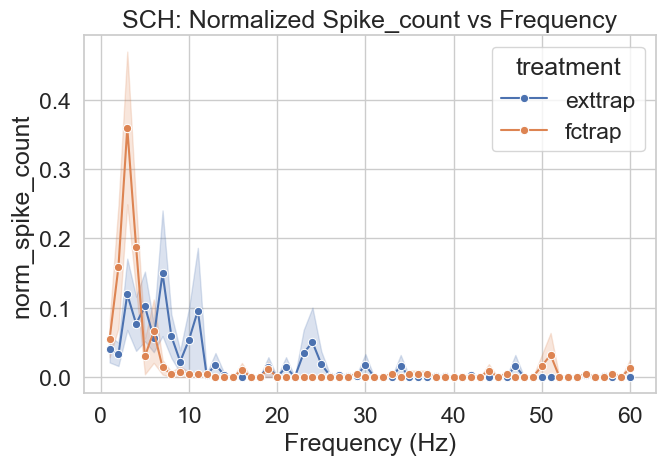

In [14]:
for stim in stim_types:
    norm_col = f'norm_{metrics[stim]}'
    plt.figure(figsize=(7, 5))
    sns.lineplot(data=dfs[stim], x='freq', y=norm_col, hue='treatment', errorbar='se', marker='o')
    plt.title(f'{stim.upper()}: Normalized {metrics[stim].capitalize()} vs Frequency')
    plt.xlabel('Frequency (Hz)')
    plt.ylabel(norm_col)
    plt.tight_layout()
    plt.show()


### 11. Divide to Frequency Bands

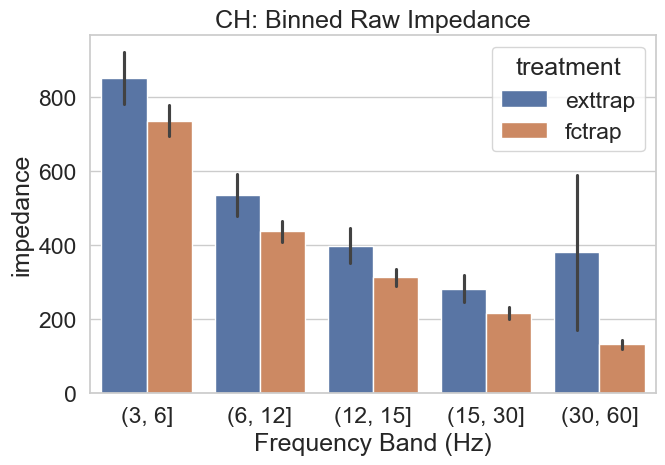

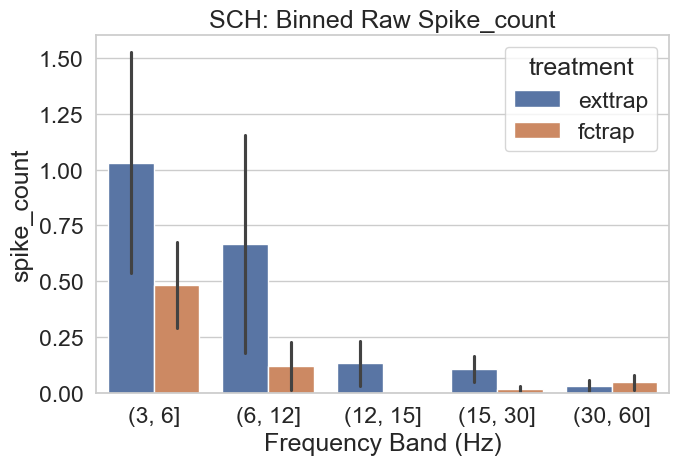

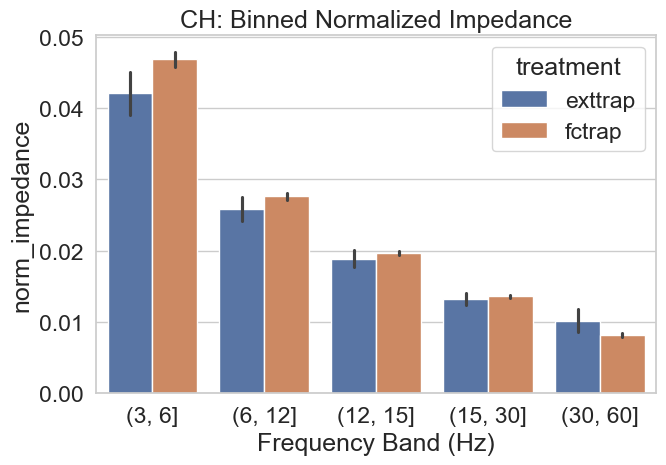

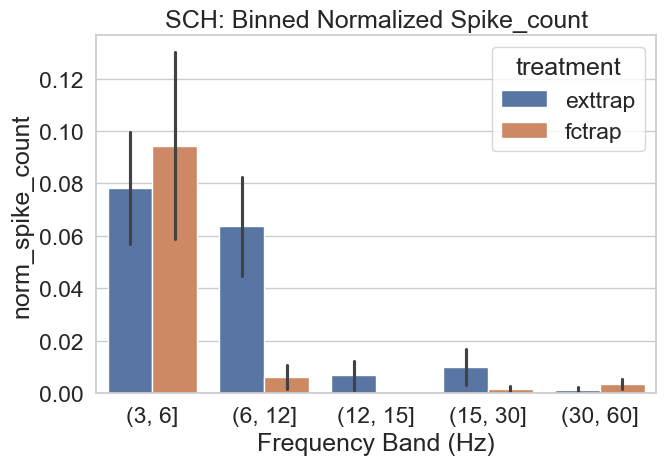

In [15]:
for stim in stim_types:
    metric = metrics[stim]
    plt.figure(figsize=(7, 5))
    sns.barplot(data=dfs_binned_raw[stim], x='freq_bins', y=metric, hue='treatment', errorbar='se')
    plt.title(f'{stim.upper()}: Binned Raw {metric.capitalize()}')
    plt.xlabel('Frequency Band (Hz)')
    plt.ylabel(metric)
    plt.tight_layout()
    plt.show()

for stim in stim_types:
    norm_col = f'norm_{metrics[stim]}'
    plt.figure(figsize=(7, 5))
    sns.barplot(data=dfs_binned_norm[stim], x='freq_bins', y=norm_col, hue='treatment', errorbar='se')
    plt.title(f'{stim.upper()}: Binned Normalized {metrics[stim].capitalize()}')
    plt.xlabel('Frequency Band (Hz)')
    plt.ylabel(norm_col)
    plt.tight_layout()
    plt.show()


### 12. Deltas

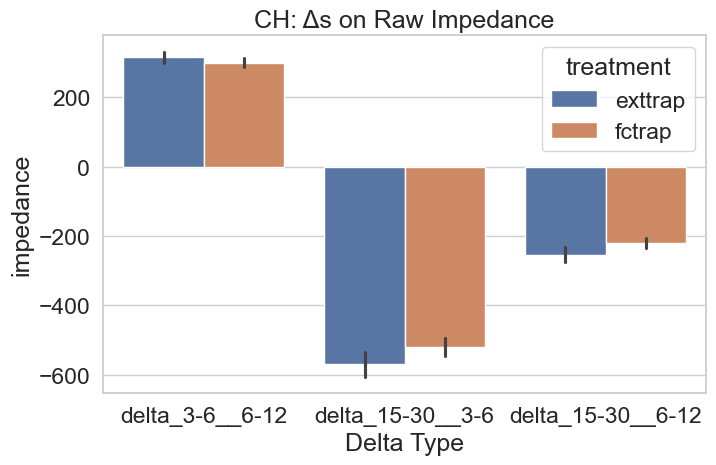

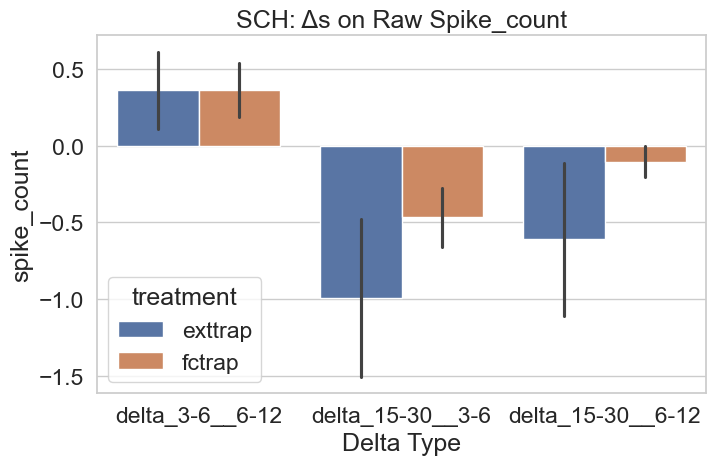

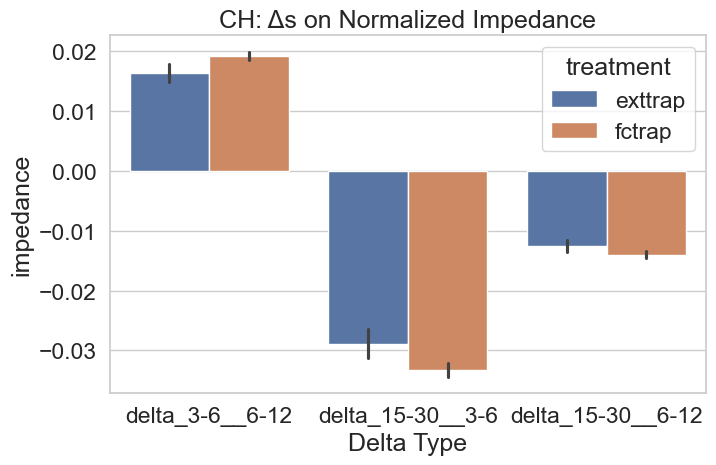

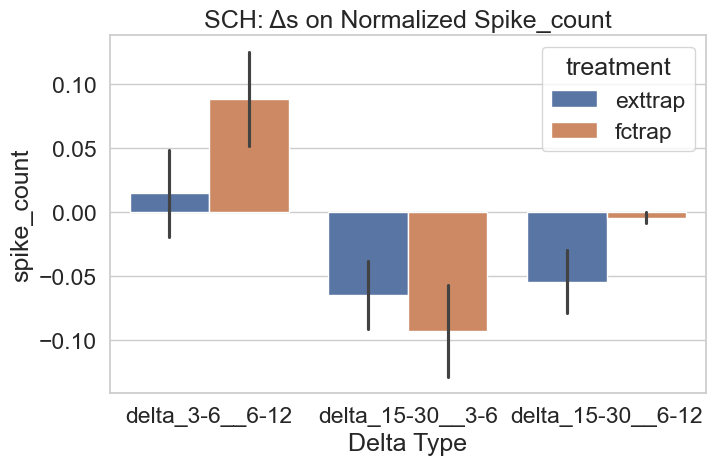

In [16]:
for stim in stim_types:
    metric = metrics[stim]
    plt.figure(figsize=(7.5, 5))
    sns.barplot(data=deltas_raw[stim], x='delta_type', y=metric, hue='treatment', errorbar='se')
    plt.title(f'{stim.upper()}: Δs on Raw {metric.capitalize()}')
    plt.xlabel('Delta Type')
    plt.ylabel(metric)
    plt.tight_layout()
    plt.show()

for stim in stim_types:
    metric = metrics[stim]
    plt.figure(figsize=(7.5, 5))
    sns.barplot(data=deltas_norm[stim], x='delta_type', y=metric, hue='treatment', errorbar='se')
    plt.title(f'{stim.upper()}: Δs on Normalized {metric.capitalize()}')
    plt.xlabel('Delta Type')
    plt.ylabel(metric)
    plt.tight_layout()
    plt.show()